### Function Approximation
Today we will explore some issues related to function approximation.

In [1]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages


  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`

In [2]:
# load some packages we will need today
using ApproxFun, Plots, LinearAlgebra, PrettyTables, FastGaussQuadrature

## Simple example
We start with a simple example of monomial basis.

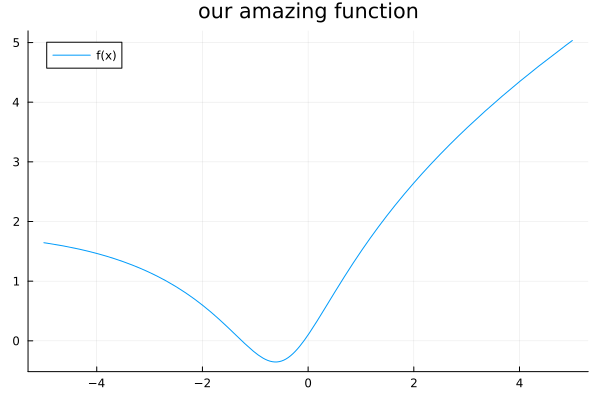

In [3]:
# test function
f1(x) = log(x^2+x + 1) + 0.3*x + 0.1
# plot it to see what happens
plot(f1, -5, 5, label="f(x)", legend=:topleft, title = "our amazing function")

In [11]:
J = 20 
nodes = LinRange(-3,3,J+1) # J+1 nodes between -3 and 3
Phi = Array{Float64}(undef,J+1,J+1)

for j = 0:J
    Phi[:,j+1] = nodes[:].^j
end
betas = Phi\f1.(nodes) # solve the linear system

21-element Vector{Float64}:
  0.09999999999979536
  1.3008834591990397
  0.49962378248384925
 -0.6822906586051485
  0.2571600611060536
  0.2787947243381306
 -0.3760797429346555
 -0.032340528353114815
  0.24898152003148477
 -0.02936993397362382
  ⋮
  0.029165954370542518
 -0.004476537311077304
 -0.005288108865774866
  0.0006209537688031207
  0.0005956496474560347
 -4.491634482301328e-5
 -3.7574411211974495e-5
  1.3253205540833758e-6
  1.0083118346345106e-6

In [12]:
f_hat(x, betas ,J) = sum([betas[j+1]*x^j for j = 0:J])

f_hat (generic function with 1 method)

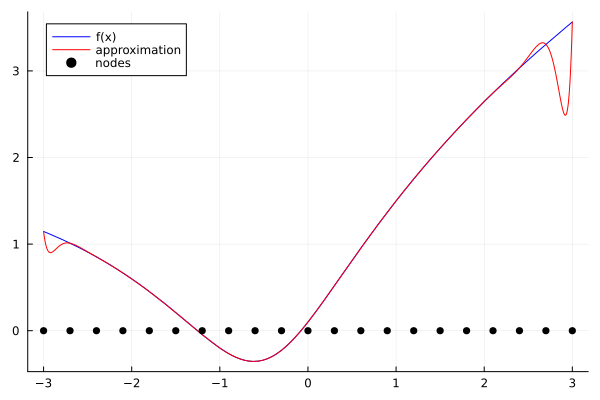

In [13]:
plot(f1, -3, 3, label="f(x)", legend=:topleft,color = :blue)
plot!(x->f_hat(x,betas,J),  -3, 3, label="approximation", legend=:topleft,color = :red)
scatter!(nodes,zeros(J+1),label="nodes", legend=:topleft,color = :black)

In [14]:
## let's see if the Phi matrix is nice...
vec_cond = []
for J = 1:15 
    
    nodes = LinRange(-3,3,J+1) # J+1 nodes between -3 and 3
    Phi = Array{Float64}(undef,J+1,J+1)
    for j = 0:J
        Phi[:,j+1] = nodes[:].^j
    end
    push!(vec_cond,cond(Phi))
end
pretty_table([collect(1:1:15) vec_cond],header = (["Order","Condition number"]),formatters = (ft_printf("%5.0f"),ft_printf("%12.6f")))

┌───────┬──────────────────┐
│ Order │ Condition number │
├───────┼──────────────────┤
│     1 │                3 │
│     2 │               13 │
│     3 │               31 │
│     4 │              135 │
│     5 │              523 │
│     6 │             2075 │
│     7 │             8802 │
│     8 │            37512 │
│     9 │           161911 │
│    10 │           708536 │
│    11 │          3123369 │
│    12 │         13866047 │
│    13 │         61937800 │
│    14 │        278039997 │
│    15 │       1253590599 │
└───────┴──────────────────┘


## Runge phenomenon


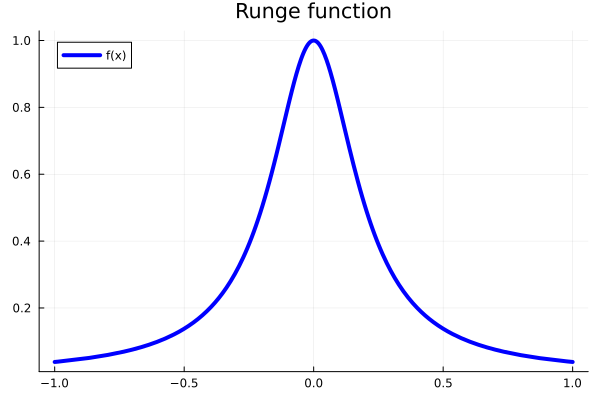

In [15]:
# evaluate
runge(x) = 1/(1+25x^2)
my_plot = plot(runge, -1, 1, label="f(x)", legend=:topleft,color = :blue,linewidth = 4,title = "Runge function")

my_plot = Plot{Plots.GRBackend() n=6}


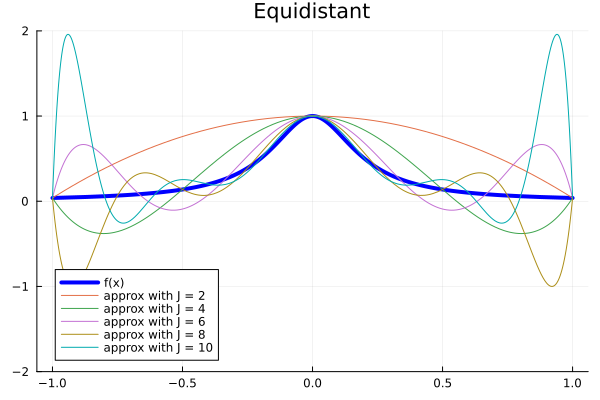

In [18]:
function get_betas(f,a,b,J)

    nodes = LinRange(a,b,J+1) # J+1 nodes, equidistant
    Phi = Array{Float64}(undef,J+1,J+1)

    for j = 0:J
        Phi[:,j+1] = nodes[:].^j
    end
    betas = Phi\f.(nodes) # solve the linear system
end

maxJ = 20
Beta_mat = zeros(maxJ,maxJ+1)


for J = 1:maxJ
    Beta_mat[J,1:J+1] = get_betas(runge,-1,1,J)
end


my_plot = plot(runge, -1, 1, label="f(x)", legend=:topleft,color = :blue,linewidth = 4,title = "Equidistant")

for j = 2:2:10
plot!(my_plot, x->f_hat(x,Beta_mat[j,:],j), -1, 1, label="approx with J = $j", legend=:bottomleft, ylim = [-2, 2])
end
@show my_plot


my_plot2 = Plot{Plots.GRBackend() n=6}


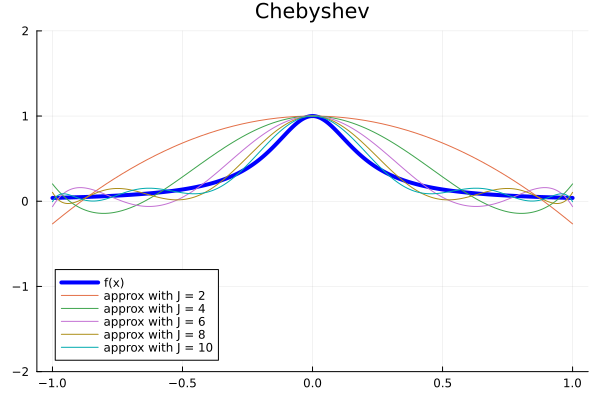

In [19]:



function get_betas_chebnodes(f,a,b,J)

    nodes =  (b-a)/2* gausschebyshev(J+1)[1] .+ (b+a)/2  # J+1 nodes, equidistant
    Phi = Array{Float64}(undef,J+1,J+1)

    for j = 0:J
        Phi[:,j+1] = nodes[:].^j
    end
    betas = Phi\f.(nodes) # solve the linear system
end

maxJ = 20
Beta_mat = zeros(maxJ,maxJ+1)


for J = 1:maxJ
    Beta_mat[J,1:J+1] = get_betas_chebnodes(runge,-1,1,J)
end


my_plot2 = plot(runge, -1, 1, label="f(x)", legend=:topleft,color = :blue,linewidth = 4,title = "Chebyshev")

for j = 2:2:10
plot!(my_plot2, x->f_hat(x,Beta_mat[j,:],j), -1, 1, label="approx with J = $j", legend=:bottomleft, ylim = [-2, 2])
end
@show my_plot2



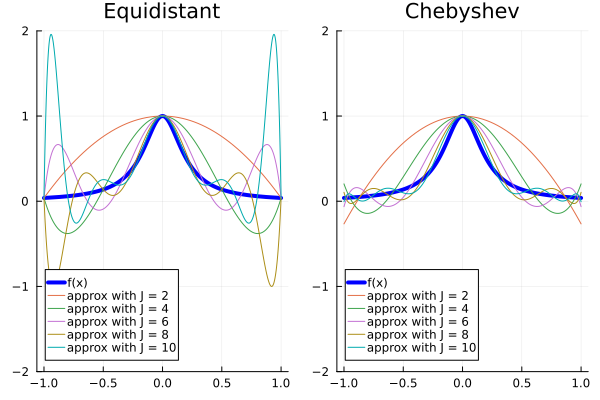

In [20]:
plot(my_plot, my_plot2)

## Chebyshev polynomials

In [24]:
# this uses ApproxFun package
# first see an example of how this works

space = Chebyshev(-1..1)
runge_cheb_approx = Fun(runge,space)

Fun(Chebyshev(-1 .. 1), [0.196116, 0.0, -0.263611, 0.0, 0.177167, 0.0, -0.11907, 0.0, 0.0800245, 0.0  …  0.0, 1.23686e-16, 0.0, -7.25753e-17, 0.0, 5.85526e-17, 0.0, -3.05491e-17, 0.0, 2.75257e-17])

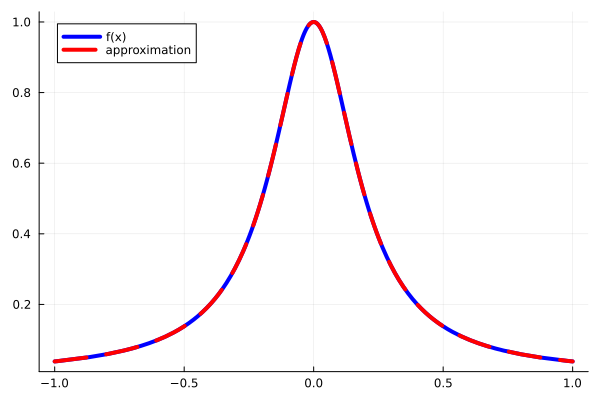

In [25]:
my_plot3 = plot(runge, -1, 1, label="f(x)", legend=:topleft,color = :blue,linewidth = 4)
plot!(my_plot3,runge_cheb_approx, -1, 1, label="approximation", legend=:topleft,color = :red,linestyle=:dash, linewidth = 4)

In [26]:
# without J?
runge_cheb_approx2 = Fun(runge,space)
ncoefficients(runge_cheb_approx2)

189

In [28]:
# what is this one?
cheb0= Fun(space,[1])
cheb1 = Fun(space,[0,1])
cheb2 = Fun(space,[0,0,1])
cheb3 = Fun(space,[0,0,0,1])
cheb4 = Fun(space,[0,0,0,0,1])

Fun(Chebyshev(-1 .. 1), [0, 0, 0, 0, 1])

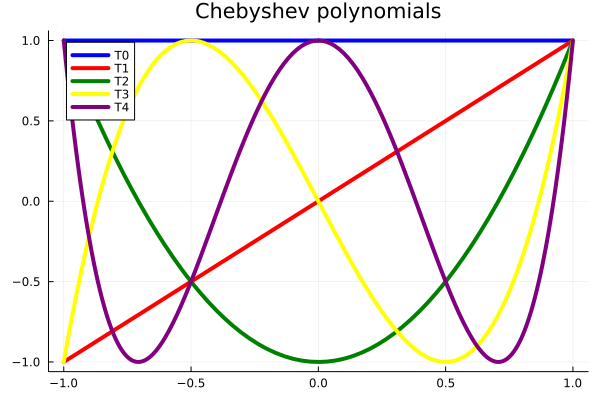

In [29]:
plot(cheb0, -1, 1, label="T0", legend=:topleft,color = :blue,linewidth = 4,title = "Chebyshev polynomials")
plot!(cheb1, -1, 1, label="T1", legend=:topleft,color = :red,linewidth = 4)
plot!(cheb2, -1, 1, label="T2", legend=:topleft,color = :green,linewidth = 4)
plot!(cheb3, -1, 1, label="T3", legend=:topleft,color = :yellow,linewidth = 4)
plot!(cheb4, -1, 1, label="T4", legend=:topleft,color = :purple,linewidth = 4)

In [30]:
## let's see if the Phi matrix is nice...
vec_cond = []
for J = 1:15 
    space = Chebyshev(-1..1)
    nodes = points(space,J+1)
    Phi = Array{Float64}(undef,J+1,J+1)
    vec_one = [1]
    
    for j = 0:J
        cheb = Fun(space,vec_one)
        Phi[:,j+1] = cheb.(nodes)
        pushfirst!(vec_one,0)
    end
    push!(vec_cond,cond(Phi))
end
pretty_table([collect(1:1:15) vec_cond],header = (["Order","Condition number"]),formatters = (ft_printf("%5.0f"),ft_printf("%12.6f")))

┌───────┬──────────────────┐
│ Order │ Condition number │
├───────┼──────────────────┤
│     1 │                1 │
│     2 │                1 │
│     3 │                1 │
│     4 │                1 │
│     5 │                1 │
│     6 │                1 │
│     7 │                1 │
│     8 │                1 │
│     9 │                1 │
│    10 │                1 │
│    11 │                1 │
│    12 │                1 │
│    13 │                1 │
│    14 │                1 │
│    15 │                1 │
└───────┴──────────────────┘


In [31]:
# investigate
J = 10
space = Chebyshev(-1..1)
nodes = points(space,J)
Phi = Array{Float64}(undef,J,J)
vec_one = [1]

for j = 1:J
    cheb = Fun(space,vec_one)
    Phi[:,j] = cheb.(nodes)
    pushfirst!(vec_one,0)
end

@show Phi'*Phi

Phi' * Phi = [10.0 0.0 -5.551115123125783e-16 0.0 1.1102230246251565e-16 5.551115123125783e-16 2.220446049250313e-15 6.661338147750939e-16 4.9960036108132044e-15 -9.71445146547012e-16; 0.0 4.999999999999999 -3.471079590272313e-16 -3.077105662952467e-16 9.49631914213213e-17 1.271730040698101e-15 7.09860188228985e-16 3.9326334323108934e-15 -1.6345640189529858e-16 6.046462015160462e-15; -5.551115123125783e-16 -3.471079590272313e-16 5.000000000000001 3.5524702672366063e-16 2.2806196632569593e-16 2.5494286974773903e-16 3.5634798919386644e-15 -2.1119781104934335e-16 4.537369458074783e-15 -2.6821750531662244e-16; 0.0 -3.077105662952467e-16 3.5524702672366063e-16 5.0 1.1562425126430677e-16 2.444406975995493e-15 -6.97176135830966e-16 4.738101386460333e-15 -1.0354391442249955e-16 4.055377547133063e-15; 1.1102230246251565e-16 9.49631914213213e-17 2.2806196632569593e-16 1.1562425126430677e-16 5.000000000000002 -5.045983314406548e-16 4.160623272296452e-15 -6.589844164296286e-16 4.1304578121760255e-

10×10 Matrix{Float64}:
 10.0           0.0          -5.55112e-16  …   4.996e-15    -9.71445e-16
  0.0           5.0          -3.47108e-16     -1.63456e-16   6.04646e-15
 -5.55112e-16  -3.47108e-16   5.0              4.53737e-15  -2.68218e-16
  0.0          -3.07711e-16   3.55247e-16     -1.03544e-16   4.05538e-15
  1.11022e-16   9.49632e-17   2.28062e-16      4.13046e-15   1.01979e-15
  5.55112e-16   1.27173e-15   2.54943e-16  …   7.0005e-16    2.21369e-15
  2.22045e-15   7.0986e-16    3.56348e-15      2.60398e-15   5.26961e-16
  6.66134e-16   3.93263e-15  -2.11198e-16      6.33774e-16   1.24468e-15
  4.996e-15    -1.63456e-16   4.53737e-15      5.0          -1.08992e-15
 -9.71445e-16   6.04646e-15  -2.68218e-16     -1.08992e-15   5.0

## Warning

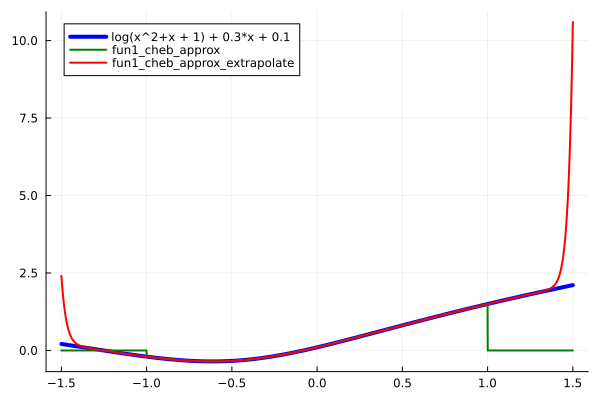

In [33]:
# we use Chebyshev interpolation to approximate the functionn f1(x) = log(x^2+x + 1) + 0.3*x + 0.1

space = Chebyshev(-1..1)
fun1_cheb_approx = Fun(f1,space)
fun1_cheb_approx_extrapolate(x) = extrapolate(fun1_cheb_approx,x )

plot(f1, -1.5, 1.5, label="log(x^2+x + 1) + 0.3*x + 0.1", legend=:topleft,color = :blue,linewidth = 4)
plot!(fun1_cheb_approx, -1.5, 1.5, label="fun1_cheb_approx", legend=:topleft,color = :green,linewidth = 2)
plot!(fun1_cheb_approx_extrapolate,  -1.5, 1.5, label="fun1_cheb_approx_extrapolate", legend=:topleft,color = :red,linewidth = 2)
